# 15.8.1 From Context-Independent to Context-Sensitive

Recall the experiments in Section 15.4 and Section 15.7. For instance, word2vec and GloVe both assign the same pretrained vector to the same word regardless of the context of the word (if any). Formally, a context-independent representation of any token x is a function f (x) that only takes x as its input. Given the abundance of polysemy and complex semantics in natural languages, context-independent representations have obvious limitations. For instance, the word “crane” in contexts “a crane is flying” and “a crane driver came” has completely different meanings; thus, the same word may be assigned different representations depending on contexts.

This motivates the development of context-sensitive word representations, where representa- tions of words depend on their contexts. Hence, a context-sensitive representation of token x is a function f (x, c(x)) depending on both x and its context c(x). Popular context-sensitive representations include TagLM (language-model-augmented sequence tagger) (Peters et al., 2017), CoVe (Context Vectors) (McCann et al., 2017), and ELMo (Embeddings from Lan- guage Models) (Peters et al., 2018).

For example, by taking the entire sequence as input, ELMo is a function that assigns a representation to each word from the input sequence. Specifically, ELMo combines all the intermediate layer representations from pretrained bidirectional LSTM as the output representa- tion. Then the ELMo representation will be added to a downstream task’s existing supervised model as additional features, such as by concatenating ELMo representation and the origi- nal representation (e.g., GloVe) of tokens in the existing model. On the one hand, all the weights in the pretrained bidirectional LSTM model are frozen after ELMo representations are added. On the other hand, the existing supervised model is specifically customized for a given task. Leveraging different best models for different tasks at that time, adding ELMo improved the state of the art across six natural language processing tasks: sentiment analy- sis, natural language inference, semantic role labeling, coreference resolution, named entity recognition, and question answering.

# 15.8.2 From Task-Specific to Task-Agnostic

Although ELMo has significantly improved solutions to a diverse set of natural language processing tasks, each solution still hinges on a task-specific architecture. However, it is practically non-trivial to craft a specific architecture for every natural language processing task. The GPT (Generative Pre-Training) model represents an effort in designing a general taskagnostic model for context-sensitive representations (Radford et al., 2018). Built on a Transformer decoder, GPT pretrains a language model that will be used to represent text sequences. When applying GPT to a downstream task, the output of the language model will be fed into an added linear output layer to predict the label of the task. In sharp contrast to ELMo that freezes parameters of the pretrained model, GPT fine-tunes all the parameters in the pretrained Transformer decoder during supervised learning of the downstream task. GPT was evaluated on twelve tasks of natural language inference, question answering, sentence similarity, and classification, and improved the state of the art in nine of them with minimal changes to the model architecture.

However, due to the autoregressive nature of language models, GPT only looks forward (leftto-right). In contexts “i went to the bank to deposit cash” and “i went to the bank to sit down”, as “bank” is sensitive to the context to its left, GPT will return the same representation for “bank”, though it has different meanings.

# 15.8.3 BERT: Combining the Best of Both Worlds

As we have seen, ELMo encodes context bidirectionally but uses task-specific architectures; while GPT is task-agnostic but encodes context left-to-right. Combining the best of both worlds, BERT (Bidirectional Encoder Representations from Transformers) encodes context bidirectionally and requires minimal architecture changes for a wide range of natural language processing tasks (Devlin et al., 2018). Using a pretrained Transformer encoder, BERT is able to represent any token based on its bidirectional context. During supervised learning of downstream tasks, BERT is similar to GPT in two aspects. First, BERT representations will be fed into an added output layer, with minimal changes to the model architecture depending on nature of tasks, such as predicting for every token vs. predicting for the entire sequence. Second, all the parameters of the pretrained Transformer encoder are fine-tuned, while the additional output layer will be trained from scratch. Fig. 15.8.1 depicts the differences among ELMo, GPT, and BERT.

BERT further improved the state of the art on eleven natural language processing tasks under broad categories of (i) single text classification (e.g., sentiment analysis), (ii) text pair classification (e.g., natural language inference), (iii) question answering, (iv) text tagging (e.g., named entity recognition). All proposed in 2018, from context-sensitive ELMo to taskagnostic GPT and BERT, conceptually simple yet empirically powerful pretraining of deep representations for natural languages have revolutionized solutions to various natural language processing tasks. In the rest of this chapter, we will dive into the pretraining of BERT. 

When natural language processing applications are explained in Chapter 16, we will illustrate fine-tuning of BERT for downstream applications.

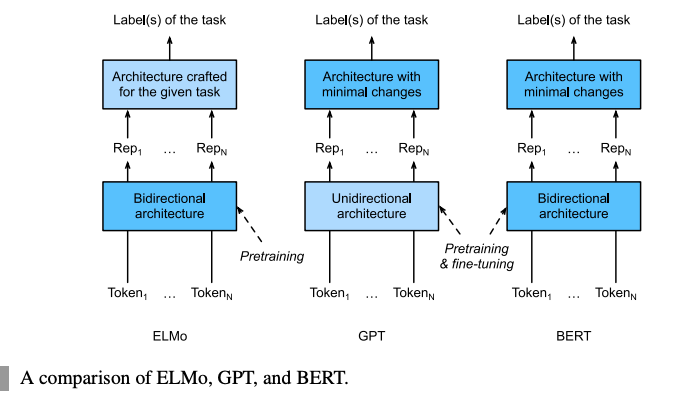

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 15.8.4 Input Representation

In natural language processing, some tasks (e.g., sentiment analysis) take single text as input, while in some other tasks (e.g., natural language inference), the input is a pair of text sequences. The BERT input sequence unambiguously represents both single text and text pairs. In the former, the BERT input sequence is the concatenation of the special classification token “< cls >”, tokens of a text sequence, and the special separation token “< sep >”. In the latter, the BERT input sequence is the concatenation of “< cls >”, tokens of the first text sequence, “< sep >”, tokens of the second text sequence, and “< sep >”. We will consistently distinguish the terminology “BERT input sequence” from other types of “sequences”. For instance, one BERT input sequence may include either one text sequence or two text sequences.

To distinguish text pairs, the learned segment embeddings $\mathbf{e}_A$ and $\mathbf{e}_B$ are added to the token embeddings of the first sequence and the second sequence, respectively. For single text inputs, only $\mathbf{e}_A$ is used.

The following get_tokens_and_segments takes either one sentence or two sentences as input, then returns tokens of the BERT input sequence and their corresponding segment IDs.

In [3]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

BERT chooses the Transformer encoder as its bidirectional architecture. Common in the Transformer encoder, positional embeddings are added at every position of the BERT input sequence. However, different from the original Transformer encoder, BERT uses learnable positional embeddings. To sum up, Fig. 15.8.2 shows that the embeddings of the BERT input sequence are the sum of the token embeddings, segment embeddings, and positional embeddings.

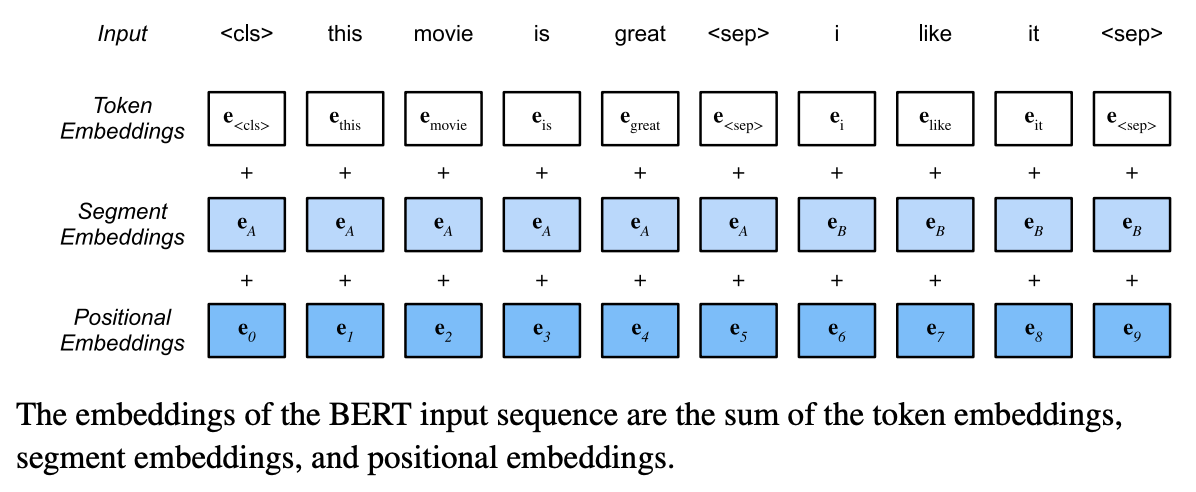

The following BERTEncoder class is similar to the TransformerEncoder class as implemented in Section 11.7. Different from TransformerEncoder, BERTEncoder uses segment embeddings and learnable positional embeddings.

In [4]:
#@save
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
        num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
        num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

Suppose that the vocabulary size is 10000. To demonstrate forward inference of BERTEncoder, let’s create an instance of it and initialize its parameters.

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)

/home/solee/miniconda3/envs/dive2dl/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## 15.8.5 Pretraining Tasks

The forward inference of BERTEncoder gives the BERT representation of each token of the input text and the inserted special tokens "< cls >" and "< seq >". Next we will use these representations to compute the loss function for pretraining BERT. The pretraining is composed of the following two tasks: masked language modeling and next sentence prediction.

### Masked Language Modeling.

As illustrated, a language model predicts a token using the context on its left. To encode context bidirectionally for representing each token, BERT randomly masks tokens and uses tokens from the bidirectional context 

In [7]:
#@save
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LayerNorm(num_hiddens),
            nn.LazyLinear(vocab_size))
        
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [8]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

/home/solee/miniconda3/envs/dive2dl/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 3, 10000])

In [9]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### Next Sentence Prediction

In [11]:
#@save
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [12]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [13]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

## 15.8.6 Putting It All Together

In [14]:
#@save
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
        num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
        num_heads, num_blks, dropout,
        max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
        nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat